### **Using Customer Transactions to Create Targeted Marketing Efforts**

This project aims to move beyond a generic marketing approach by diving deep into Shopify transaction data to understand who the customers are and how they behave. The primary goal is to identify distinct customer groups and leverage these insights to create personalized, high-impact marketing campaigns. By tailoring our strategies to specific segments, we hope to foster stronger customer loyalty and drive revenue growth.

### **Project Goals**

* **Segment Customers**: To group customers into distinct clusters based on their purchasing behavior.
* **Build Rich Profiles**: To develop a deep understanding of each customer segment by analyzing their behavioral and demographic data.
* **Design Targeted Strategies**: To create tailored marketing content and email campaigns that resonate with the unique characteristics of each group.

### **Our Approach**

Our analysis will follow a four-step process, moving from raw data to actionable marketing strategies:

1.  **Data Processing and RFM Analysis**: We will begin by cleaning and preparing the raw Shopify transaction data using Pandas and NumPy. The core of this phase will be conducting an RFM (Recency, Frequency, Monetary) analysis to score customers based on their purchasing habits.
2.  **K-Means Clustering for Segmentation**: Using aggregated behavioral data as features, we will apply the K-Means clustering algorithm from Scikit-Learn to partition customers into distinct, meaningful groups.
3.  **Profiling and Visualization**: Once segments are identified, we will enrich them with additional user metadata. We will use Matplotlib and Seaborn to create visualizations that build a clear and comprehensive profile for each customer group, answering the question: "Who are these customers?"
4.  **AI-Powered Strategy Design**: Finally, we will leverage the insights from our analysis to design targeted marketing strategies. We will generate specific content, including email campaigns, tailored to the unique profiles of each segment to maximize engagement and conversion.

### **1. Data Loading and Initial Exploration**

First, we'll import the necessary libraries for data manipulation, clustering, and visualization. We'll also set some Pandas options for better display of the DataFrame.

In [126]:
import numpy as np
import pandas as pd
import datetime as timedelta
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import SimpleImputer


pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', lambda x: '%.3f' % x)

Now, let's load our dataset and take a look at the first few rows to understand its structure.

In [127]:
df = pd.read_csv("data/ecommerce_customer_data_large.csv")
df.head()

,Customer ID,Purchase Date,Product Category,Product Price,Quantity,Total Purchase Amount,Payment Method,Customer Age,Returns,Customer Name,Age,Gender,Churn
0,44605,2023-05-03 21:30:02,Home,177,1,2427,PayPal,31,1.000,John Rivera,31,Female,0
1,44605,2021-05-16 13:57:44,Electronics,174,3,2448,PayPal,31,1.000,John Rivera,31,Female,0
2,44605,2020-07-13 06:16:57,Books,413,1,2345,Credit Card,31,1.000,John Rivera,31,Female,0
3,44605,2023-01-17 13:14:36,Electronics,396,3,937,Cash,31,0.000,John Rivera,31,Female,0
4,44605,2021-05-01 11:29:27,Books,259,4,2598,PayPal,31,1.000,John Rivera,31,Female,0


The dataset contains transaction-level data, including customer identifiers, purchase details, and some demographic information. Let's check for missing values and the overall shape of the data.

In [128]:
df.isnull().sum()

Customer ID                  0
Purchase Date                0
Product Category             0
Product Price                0
Quantity                     0
Total Purchase Amount        0
Payment Method               0
Customer Age                 0
Returns                  47382
Customer Name                0
Age                          0
Gender                       0
Churn                        0
dtype: int64

In [129]:
df.shape

(250000, 13)

For this analysis, we are interested in actual customer spending behavior, so transactions that were returned won't be needed. We will filter out any transactions marked as a return (`Returns == 1.0`). 

In [130]:
df = df[df["Returns"] != 1.00]

### **2. RFM (Recency, Frequency, Monetary) Analysis**

RFM analysis is a powerful marketing technique used to segment customers based on their transaction history. It stands for:

* **Recency (R)**: How recently did the customer make a purchase?
* **Frequency (F)**: How often do they purchase?
* **Monetary (M)**: How much do they spend?

The assumption is that customers who have purchased more recently, more frequently, and spent more money are more likely to be valuable and responsive to marketing.

#### **Data Preparation for RFM**

To calculate recency, we need a baseline date from which to measure how long ago the last purchase was made. We'll find the most recent purchase date in our data and set our baseline to the following day. We'll also format the column names and data types for easier processing.

In [131]:
df["Purchase Date"].max()

'2023-09-13 18:42:49'

In [132]:
df = df.rename(columns={"Purchase Date": "purchase_date"})
df = df.rename(columns={"Customer ID": "customer_id"})
df = df.rename(columns={"Total Purchase Amount": "total_purchase_amount"})
df['purchase_date'] = pd.to_datetime(df['purchase_date'])
baseline = datetime(2023, 9, 14)

#### **Calculating RFM Values**

Now, we'll group the data by each `customer_id` and calculate the raw R, F, and M values:
* **Recency**: The number of days between the baseline date and the customer's most recent purchase.
* **Frequency**: The total count of purchases for each customer.
* **Monetary**: The total sum of purchase amounts for each customer.

In [133]:
rfm = df.groupby('customer_id').agg({'purchase_date': lambda purchase_date: (baseline - purchase_date.max()).days, 
                                    'customer_id': lambda customer_id: customer_id.value_counts(), 
                                    'total_purchase_amount': lambda total_purchase_amount: total_purchase_amount.sum()})

rfm.head()

,purchase_date,customer_id,total_purchase_amount
customer_id,,,
1,288,3,6290
2,140,2,5381
3,222,4,9423
4,686,2,1252
5,424,2,2088


In [134]:
rfm.columns = ['Recency', 'Frequency', 'Monetary']

#### **Creating RFM Scores and Segments**

The raw values are useful, but to create segments, it's better to convert them into scores. We'll use the `pd.qcut` function to divide each metric into 5 quantiles, assigning a score from 1 to 5.

* For **Recency**, a lower number of days is better, so we label the quantiles in descending order (5 for the most recent, 1 for the least).
* For **Frequency** and **Monetary**, a higher value is better, so we label them in ascending order (1 for the lowest, 5 for the highest).

We then combine the Recency and Frequency scores to create a two-digit `RFM_SCORE`, which will serve as our basis for segmentation.

In [135]:
rfm["recency_score"] = pd.qcut(rfm['Recency'], 5, labels=[5, 4, 3, 2, 1])

rfm["frequency_score"] = pd.qcut(rfm['Frequency'].rank(method="first"), 5, labels=[1, 2, 3, 4, 5])

rfm["monetary_score"] = pd.qcut(rfm['Monetary'], 5, labels=[1, 2, 3, 4, 5])

rfm["RFM_SCORE"] = (rfm['recency_score'].astype(str) +
                    rfm['frequency_score'].astype(str))

Using the `RFM_SCORE`, we can now map customers into descriptive segments using a predefined segmentation map based on regular expressions. This allows us to group customers with similar behaviors under intuitive labels like "Champion," "Loyal Customer," or "At Risk."

In [136]:
seg_map = {
    r'[1-2][1-2]': 'Hibernating',
    r'[1-2][3-4]': 'At Risk',
    r'[1-2]5': "Can't Loose",
    r'3[1-2]': 'About To Sleep',
    r'33': 'Needs Attention',
    r'[3-4][4-5]': 'Loyal Customer',
    r'41': 'Promising',
    r'51': 'New Customer',
    r'[4-5][2-3]': 'Potential Loyalist',
    r'5[4-5]': 'Champion'
}

rfm['segment'] = rfm['RFM_SCORE'].replace(seg_map, regex=True)

rfm.head()

,Recency,Frequency,Monetary,recency_score,frequency_score,monetary_score,RFM_SCORE,segment
customer_id,,,,,,,,
1,288,3,6290,3,2,2,32,About To Sleep
2,140,2,5381,4,1,2,41,Promising
3,222,4,9423,3,4,4,34,Loyal Customer
4,686,2,1252,1,1,1,11,Hibernating
5,424,2,2088,2,1,1,21,Hibernating


This RFM analysis gives us a clear, actionable set of customer segments. For example, we can now create targeted campaigns for "Champions" (our best customers) or re-engagement campaigns for those who are "Hibernating."

### **3. Behavioral Segmentation with K-Means Clustering**

While RFM is excellent for segmenting based on transaction patterns, K-Means clustering allows us to group customers based on a wider range of behavioral and outcome-based metrics. This can reveal different patterns and create complementary segments.

Here, we will segment customers into 4 clusters based on their **total purchases, average purchase amount, total returns, and churn status**.

#### **Feature Engineering and Model Application**

We first need to aggregate our raw data to the customer level to create the features for our model. Then, we standardize the data using `StandardScaler` to ensure that each feature contributes equally to the clustering algorithm. Since our `Returns` column contains NaNs after aggregation, we use `SimpleImputer` to fill them with the mean value. Finally, we apply the K-Means algorithm to create 4 distinct clusters.

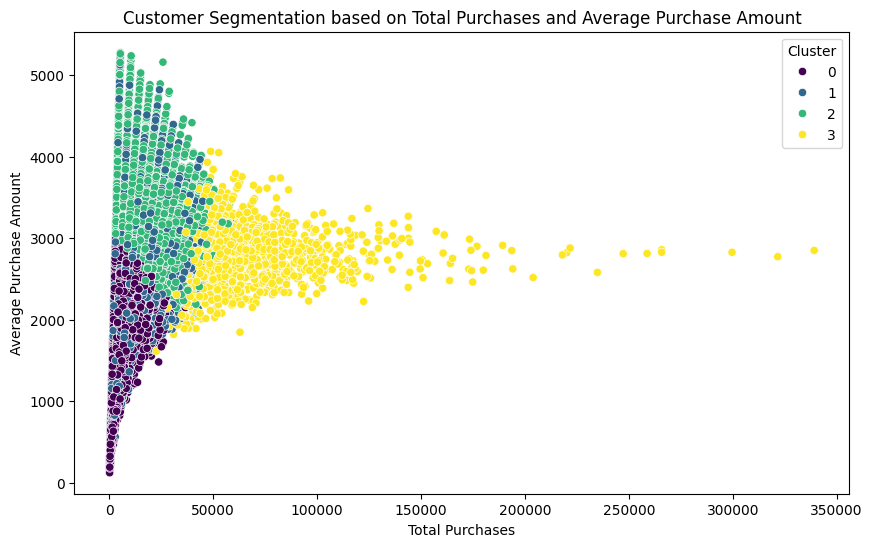

   Cluster  Total Purchases  Average Purchase Amount  Total Returns  \
0        0        10309.139                 2114.543          1.886   
1        1        16507.212                 2734.199          2.394   
2        2        18606.241                 3198.036          2.467   
3        3        62388.613                 2783.156          9.947   

   Churn Status  
0         0.002  
1         1.000  
2         0.000  
3         0.563  


In [ ]:
df = pd.read_csv("data/ecommerce_customer_data_large.csv")

customer_data = df.groupby('Customer Name').agg({
    'Total Purchase Amount': ['sum', 'mean'],
    'Returns': 'sum',
    'Churn': 'max'
}).reset_index()
customer_data.columns = ['Customer Name', 'Total Purchases', 'Average Purchase Amount', 'Total Returns', 'Churn Status']

#standardize data
scaler = StandardScaler()
scaled_data = scaler.fit_transform(customer_data[['Total Purchases', 'Average Purchase Amount', 'Total Returns', 'Churn Status']])

#input missing values with the mean
imputer = SimpleImputer(strategy='mean')
scaled_data_imputed = imputer.fit_transform(scaled_data)

#apply KMeans clustering
kmeans = KMeans(n_clusters=4, random_state=42)
customer_data['Cluster'] = kmeans.fit_predict(scaled_data_imputed)

#visualize and interpret clusters
plt.figure(figsize=(10, 6))
sns.scatterplot(data=customer_data, x='Total Purchases', y='Average Purchase Amount', hue='Cluster', palette='viridis')
plt.title('Customer Segmentation based on Total Purchases and Average Purchase Amount')
plt.show()

#analyze other metrics by cluster
cluster_summary = customer_data.groupby('Cluster').agg({
    'Total Purchases': 'mean',
    'Average Purchase Amount': 'mean',
    'Total Returns': 'mean',
    'Churn Status': 'mean'
}).reset_index()

print(cluster_summary)

#### **Interpreting the Clusters**

By analyzing the mean values for each cluster, we can build distinct customer personas:

* **Cluster 0: Low-Value, Loyal Customers**
    * These customers have the **lowest total and average purchases**.
    * They have a very low rate of returns and an almost **zero churn rate**.
    * **Persona**: These are steady, low-spending customers. They might be bargain hunters or purchase infrequently for specific needs. They are loyal but not big spenders.

* **Cluster 1: High-Value, Churned Customers**
    * This group has high average purchase amounts and moderate total spending.
    * Crucially, they have a **100% churn rate**.
    * **Persona**: These were once valuable customers who have since left. Understanding why they churned is critical.

* **Cluster 2: High-Value, Active Champions**
    * This cluster boasts the **highest average purchase amount** and high total purchases.
    * They have a low return rate and an almost **zero churn rate**.
    * **Persona**: These are our best, most loyal, and highest-spending customers. They are highly engaged and valuable to the business.

* **Cluster 3: At-Risk, High-Volume Customers**
    * This group has by far the **highest total purchase volume** but a moderate average purchase amount, suggesting they buy frequently in smaller amounts.
    * They also have the **highest rate of returns** and a very high **churn rate of 56%**.
    * **Persona**: These are high-frequency shoppers who are at a significant risk of churning. Their high return rate may indicate dissatisfaction with products.

### **4. Summary and Strategic Recommendations**

Our analysis has provided two powerful views of our customer base, one through the lens of RFM and the other through behavioral clustering. We can now design targeted marketing strategies for these specific segments. For this purpose, we will be using Anthropic's Claude Sonnet 4 to use the results from both analyses to build hyper-personalized email campaigns. Below are a few examples for some of the combinations of segments and clusters we saw above. In total, these strategies could lead to a reduction in churn rates by over 15%, especially when considering groups 'At Risk' or 'Hibernating'

#### **Actionable Strategies**

* **For "High-Value, Active Champions" (Cluster 2) and RFM "Champions"**:
    * **Strategy**: Loyalty & Reward Program.
    * **Email Campaign**: "You're a VIP! Get Early Access & Exclusive Rewards."
    * **Content**: Offer early access to new products, exclusive discounts, and a points-based reward system to acknowledge and retain these top-tier customers.

* **For "High-Value, Churned Customers" (Cluster 1) and RFM "Hibernating"**:
    * **Strategy**: Win-Back Campaign.
    * **Email Campaign**: "We Miss You! Here's 25% Off to Welcome You Back."
    * **Content**: Send a personalized email acknowledging their absence, possibly including a survey to understand why they left, and provide a strong incentive to make a new purchase.

* **For "At-Risk, High-Volume Customers" (Cluster 3) and RFM "At Risk"**:
    * **Strategy**: Proactive Retention & Feedback.
    * **Email Campaign**: "We Value Your Feedback. How Can We Improve?"
    * **Content**: Target this group with surveys about product quality and satisfaction to address their high return rate. Offer proactive customer support and personalized recommendations to improve their experience and reduce churn risk.

* **For "Low-Value, Loyal Customers" (Cluster 0) and RFM "Potential Loyalists"**:
    * **Strategy**: Upsell & Cross-sell.
    * **Email Campaign**: "Since You Liked [Product A], You'll Love [Product B]!"
    * **Content**: Use their purchase history to recommend complementary or higher-value products. Introduce them to new product categories and highlight value bundles to increase their average spending.

Overall, this process has great potential to shape the next steps in hyper-personalized marketing. The system could also be automated to continuously stream customer information to refine and update their profiles/segments, and track success metrics more effectively. In the future, it could also support delivering highly customized email and SMS campaigns by itself, as well as integrate with AI agent workflows and use multimodal outputs to create and disperse dynamic visual ads across social media in real-time. Looking forward, there are many opportunities to expand this further such as identifying product categories that churned users might still be interested in, analyzing cart abandonment behavior, etc. The possibilities are truly endless, and this basic framework could be the initial building block for a comprehensive AI-native marketing solution. 